In [1]:
cd ..

/work


In [2]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *
import glob
from pathlib import Path
import json


config_path = './configs/dbscan.json'
f = open(config_path)
config = json.load(f)

In [4]:



for out_path, log_path in zip(glob.glob('out/*.csv'), glob.glob('out/*.log')):
    print('\n')
    print(log_path)
    print(out_path)
    print('\n')
    
    # load out
    df = pd.read_csv(out_path, header=None)
    y_pred, state = df[0], df[1]
    name = Path(log_path).stem.replace('LOG_','')
    print(name)
    
    # lad dataset
    if len([dataset for dataset in list(config.keys()) if dataset in name]) > 0:
        dataset_name = [dataset for dataset in list(config.keys()) if dataset in name][0]

        dataset = Dataset(f'data/{dataset_name}.txt') 
        X, y = dataset.X, dataset.y
        
        logs = pd.read_csv(
            f'out/LOG_{name}.log',
            names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
            index_col=False
        )

        # OUT
        mask = logs['operation'] == 'similarity_calculation'
        similarity_calculation = logs[mask].groupby('point_id').sum().reset_index()
        similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

        out = pd.DataFrame({
            'point_id': np.arange(dataset.n_rows),
            'x': dataset.X[:, 0], 
            'y': dataset.X[:, 1],
            'point_type': state, # 1 - core, 0 - border, -1 - noise
            'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
        })

        out = out.merge(similarity_calculation, on='point_id')
        out.to_csv(f'./out/OUT_{name}.csv', index=False)
        
        # STAT
        params = config[dataset_name]['params_dbscan']

        score = evaluate(y_pred, dataset.y, dataset.X)
        stat = pd.DataFrame({
            'name of the input fil': dataset.name,
            '# of dimensions of a point': dataset.n_dimentions,
            '# of points in the input file': dataset.n_rows,
            'epsilon': params['epsilon'] if 'epsilon' in params else '',
            'minPts': params['minPts'] if 'minPts' in params else '',
            'k':  params['k'] if 'k' in params else '',
            'similarity': params['similarity'],
            'values of dimensions of a reference point': '[0,1]',
            'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0],
            'normalization of vectors [ms]': "",
            "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum(),
            'Clustering timer [ms]': (
                logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
                logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
            ),
            # 'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] ,
            "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum(),
            'total runtime [ms]': (
                logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
                logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
            ),
            "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum(),
            "tiknn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum(),
            "tirnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum(),
            '# of discovered clusters': sum(out['CId'] > -1),
            '# of discovered noise points': sum(out['point_type'] == -1),
            '# of discovered core points': sum(out['point_type'] == 1),
            '# of discovered border points': sum(out['point_type'] == 0),
            'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
            '|TP|': score['TP'],
            '|TN|': score['TN'],
            '# of pairs of points': len(y),
            'RAND': score['rand_score'],
            'Purity': score['purity'],
            'Silhouette coefficient': score['silhouette_score_euclidean'],
            'Davies Bouldin': score['davies_bouldin_score']
        }, index=['values']).T
        
        stat.to_csv(f'./out/STAT_{name}.csv', index=False)
        
        # DEBUG
        mask1 = logs['operation'] == '|knn_neighbors|'
        mask2 = logs['operation'] == 'knn_neighbors_id'
        mask3 = logs['operation'] == '|rnn_neighbors|'
        mask4 = logs['operation'] == 'rnn_neighbors_id'

        debug1 = (
            logs[mask1]
            .pivot_table(
                index=['point_id'], 
                columns=['operation'], 
                values= 'value', 
            )
        )
        debug1.reset_index(col_level=1, inplace=True)
        debug1.columns.name = None

        debug2 = (
            logs[mask2]
            .pivot_table(
                index=['point_id'], 
                columns=['operation'], 
                values= 'string', 
                aggfunc=lambda x: ' '.join(x)
        ))   
        debug2.reset_index(col_level=1, inplace=True)
        debug2.columns.name = None

        debug3 = (
            logs[mask3]
            .pivot_table(
                index=['point_id'], 
                columns=['operation'], 
                values= 'value', 
            )
        )
        debug3.reset_index(col_level=1, inplace=True)
        debug3.columns.name = None

        debug4 = (
            logs[mask4]
            .fillna('')
            .pivot_table(
                index=['point_id'], 
                columns=['operation'], 
                values= 'string', 
                aggfunc=lambda x: ' '.join(x)
        ))   
        debug4.reset_index(col_level=1, inplace=True)
        debug4.columns.name = None


        debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
        debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)




out/LOG_dbscanrn_compound_dataset_D2_R399_k25_cosine_dissimilarity.log
out/dbscanrn_cpp_compound_dataset.csv


dbscanrn_compound_dataset_D2_R399_k25_cosine_dissimilarity


out/LOG_dbscanrn_cpp_compound_dataset_D2_R399_k25_cosine_dissimilarity.log
out/dbscanrn_cpp_flame_dataset.csv


dbscanrn_cpp_compound_dataset_D2_R399_k25_cosine_dissimilarity


out/LOG_dbscanrn_cpp_jain_dataset_D2_R373_k81_cosine_dissimilarity.log
out/dbscanrn_cpp_jain_dataset.csv


dbscanrn_cpp_jain_dataset_D2_R373_k81_cosine_dissimilarity


out/LOG_dbscanrn_cpp_lecture_dataset_D2_R12_k2_cosine_dissimilarity.log
out/dbscanrn_cpp_lecture_dataset.csv


dbscanrn_cpp_lecture_dataset_D2_R12_k2_cosine_dissimilarity
Dataset name:  lecture_dataset
n_dimentions:  2
n_rows 12
runtime [ms]:  10.112285614013672


KeyError: 'similarity'

# Lecture dataset

Dataset name:  lecture_dataset
n_dimentions:  2
n_rows 12
runtime [ms]:  12.73488998413086


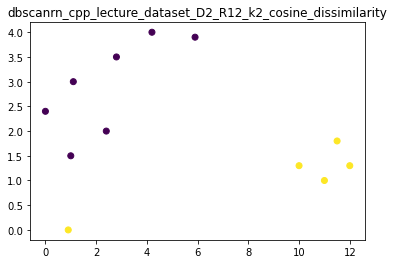

Dataset name:  lecture_dataset
n_dimentions:  2
n_rows 12
runtime [ms]:  12.393951416015625


ValueError: 'c' argument has 600 elements, which is inconsistent with 'x' and 'y' with size 12.

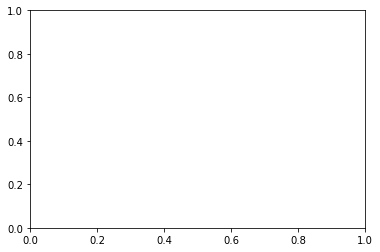

In [3]:
for out_path, log_path in zip(glob.glob('out/*.csv'), glob.glob('out/*.log')):
    name = Path(log_path).stem.replace('LOG_','')
    if len([dataset for dataset in list(config.keys()) if dataset in name]) > 0:
        dataset_name = [dataset for dataset in list(config.keys()) if dataset in name][0]
        dataset = Dataset(f'data/{dataset_name}.txt') 
        X, y = dataset.X, dataset.y
        # load out
        df = pd.read_csv(out_path, header=None)
        y_pred, state = df[0], df[1]
        display_points(X, y_pred, title=name, numerate=False)

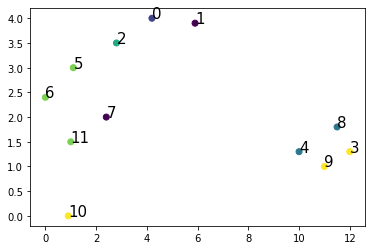

In [3]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/lecture_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_cpp_lecture_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=True)

## OUT

In [4]:
pd.options.display.max_rows = None
name = 'dbscanrn_cpp_lecture_dataset_D2_R12_k2_cosine_dissimilarity'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.005961,NaN
1,16.797322,start log,NaN,NaN,NaN
2,16.801069,normalization_time,NaN,0.003003,NaN
3,16.802307,similarity_calculation,0.0,1.000000,NaN
4,16.803142,similarity_calculation,0.0,1.000000,NaN


In [5]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,4.2,4.0,1,3,11.0
1,1,5.9,3.9,1,2,11.0
2,2,2.8,3.5,1,5,11.0
3,3,12.0,1.3,1,7,11.0
4,4,10.0,1.3,1,4,11.0


## STAT

In [14]:
params = {
    'k': 2,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [15]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.010370969772338867


,values
name of the input fil,lecture_dataset
# of dimensions of a point,2
# of points in the input file,12
epsilon,
minPts,
k,2
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],2.44
normalization of vectors [ms],


## DEBUG

In [16]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,4.0,7;2;1;11;,0.0,
1,1.0,4.0,7;0;2;11;,4.0,7;0;2;11;
2,2.0,4.0,11;0;7;1;,4.0,11;0;7;1;
3,3.0,4.0,9;4;8;10;,4.0,9;4;8;10;
4,4.0,4.0,3;8;9;10;,4.0,3;8;9;10;


# Compound dataset

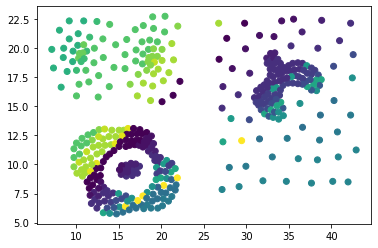

In [67]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/compound_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_cpp_compound_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [68]:
pd.options.display.max_rows = None
name = 'dbscanrn_cpp_compound_dataset_D2_R399_k25_cosine_dissimilarity'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.002800,NaN
1,2.550635,start log,NaN,NaN,NaN
2,3.191032,normalization_time,NaN,0.639938,NaN
3,3.193073,similarity_calculation,0.0,1.000000,NaN
4,3.193450,similarity_calculation,0.0,1.000000,NaN


In [69]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,26.75,22.15,1,21,398.0
1,1,29.80,22.15,1,2,398.0
2,2,31.55,21.10,1,3,398.0
3,3,27.70,20.85,1,2,398.0
4,4,29.90,19.95,1,3,398.0


## STAT

In [70]:
params = {
    'k': 4,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [71]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.0850067138671875


,values
name of the input fil,compound_dataset
# of dimensions of a point,2
# of points in the input file,399
epsilon,
minPts,
k,4
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],2.7996
normalization of vectors [ms],


## DEBUG

In [72]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,4.0,215;243;231;272;,0.0,
1,1.0,4.0,321;223;275;322;,4.0,321;223;275;322;
2,2.0,4.0,325;4;329;330;,4.0,325;4;329;330;
3,3.0,4.0,280;266;279;275;,4.0,280;266;279;275;
4,4.0,4.0,2;325;330;329;,4.0,2;325;330;329;


# Jain dataset

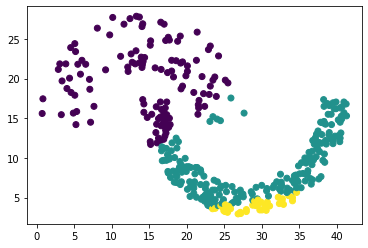

In [32]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/jain_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_cpp_jain_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [33]:
name = 'dbscanrn_cpp_jain_dataset_D2_R373_k81_cosine_dissimilarity'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False,
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.002704,NaN
1,2.115787,start log,NaN,NaN,NaN
2,2.774390,normalization_time,NaN,0.657994,NaN
3,2.776807,similarity_calculation,0.0,1.000000,NaN
4,2.777355,similarity_calculation,0.0,1.000000,NaN


In [34]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,0.85,17.45,1,2,372.0
1,1,0.75,15.60,1,2,372.0
2,2,3.30,15.45,1,2,372.0
3,3,5.25,14.20,1,2,372.0
4,4,4.90,15.65,1,2,372.0


## STAT

In [35]:
params = {
    'k': 81,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [36]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.13851380348205566


,values
name of the input fil,jain_dataset
# of dimensions of a point,2
# of points in the input file,373
epsilon,
minPts,
k,81
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],2.7038
normalization of vectors [ms],


## DEBUG

In [37]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,81.0,1;10;11;9;12;23;24;2;8;13;22;7;19;21;18;6;20;2...,0.0,
1,1.0,81.0,0;10;11;9;12;23;24;2;8;13;22;7;19;21;18;6;20;2...,81.0,0;10;11;9;12;23;24;2;8;13;22;7;19;21;18;6;20;2...
2,2.0,81.0,8;24;13;22;23;12;7;19;9;21;18;6;11;10;20;25;4;...,81.0,8;24;13;22;23;12;7;19;9;21;18;6;11;10;20;25;4;...
3,3.0,81.0,26;16;27;17;5;4;32;25;28;20;33;6;18;15;21;34;2...,81.0,26;16;27;17;5;4;32;25;28;20;33;6;18;15;21;34;2...
4,4.0,81.0,25;20;5;6;18;17;21;26;3;19;7;16;27;22;13;8;2;2...,81.0,25;20;5;6;18;17;21;26;3;19;7;16;27;22;13;8;2;2...


# Flame dataset

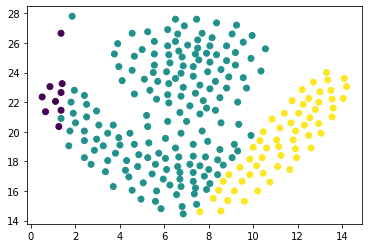

In [42]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/flame_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_cpp_flame_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [39]:
name = 'dbscanrn_flame_dataset_D2_R240_k50_cosine_dissimilarity'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.003661,NaN
1,2.569230,start log,NaN,NaN,NaN
2,2.863042,normalization_time,NaN,0.293167,NaN
3,2.865170,similarity_calculation,0.0,1.000000,NaN
4,2.865819,similarity_calculation,0.0,1.000000,NaN


In [23]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,1.85,27.80,1,2,239.0
1,1,1.35,26.65,1,2,239.0
2,2,1.40,23.25,1,2,239.0
3,3,0.85,23.05,1,2,239.0
4,4,0.50,22.35,1,2,239.0


## STAT

In [24]:
params = {
    'k': 50,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [25]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.04109025001525879


,values
name of the input fil,flame_dataset
# of dimensions of a point,2
# of points in the input file,240
epsilon,
minPts,
k,50
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],2.9801
normalization of vectors [ms],


## DEBUG

In [27]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,50.0,15;14;16;2;7;10;1;6;8;17;20;13;3;18;5;9;4;11;1...,0.0,
1,1.0,50.0,6;7;2;16;14;3;15;0;5;4;10;8;17;20;13;18;9;11;1...,50.0,6;7;2;16;14;3;15;0;5;4;10;8;17;20;13;18;9;11;1...
2,2.0,50.0,7;16;14;15;0;1;6;10;3;8;17;20;13;5;18;4;9;11;1...,50.0,7;16;14;15;0;1;6;10;3;8;17;20;13;5;18;4;9;11;1...
3,3.0,50.0,5;6;1;4;7;2;16;14;15;0;10;8;17;20;13;18;9;11;1...,50.0,5;6;1;4;7;2;16;14;15;0;10;8;17;20;13;18;9;11;1...
4,4.0,50.0,5;3;6;1;7;2;16;14;15;0;10;8;17;20;13;18;9;11;1...,50.0,5;3;6;1;7;2;16;14;15;0;10;8;17;20;13;18;9;11;1...


# R15 dataset

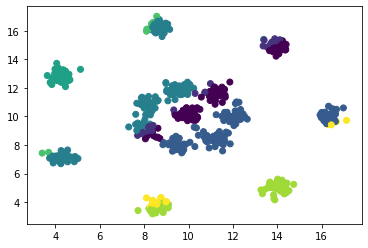

In [73]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/R15_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_cpp_R15_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, numerate=False)

## OUT

In [74]:
name = 'dbscanrn_R15_dataset_D2_R600_k10_cosine_dissimilarity'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.003179,NaN
1,2.186893,start log,NaN,NaN,NaN
2,3.748201,normalization_time,NaN,1.560831,NaN
3,3.752039,similarity_calculation,0.0,1.000000,NaN
4,3.752484,similarity_calculation,0.0,1.000000,NaN


In [75]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,9.802,10.132,1,2,599.0
1,1,10.350,9.768,1,2,599.0
2,2,10.098,9.988,1,2,599.0
3,3,9.730,9.910,1,2,599.0
4,4,9.754,10.430,1,2,599.0


## STAT

In [76]:
params = {
    'k': 7,
    'similarity': 'cosine_dissimilarity'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [77]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'knn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'rnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.16370463371276855


,values
name of the input fil,R15_dataset
# of dimensions of a point,2
# of points in the input file,600
epsilon,
minPts,
k,7
similarity,cosine_dissimilarity
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],3.1794
normalization of vectors [ms],


## DEBUG

In [78]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,8.0,94;361;7;88;117;30;84;204;,0.0,
1,1.0,8.0,29;27;87;16;32;19;6;31;,8.0,29;27;87;16;32;19;6;31;
2,2.0,8.0,89;95;113;245;38;34;35;221;,8.0,89;95;113;245;38;34;35;221;
3,3.0,8.0,374;360;18;104;119;380;26;384;,8.0,374;360;18;104;119;380;26;384;
4,4.0,8.0,378;395;22;92;93;399;381;37;,8.0,378;395;22;92;93;399;381;37;
